In [1]:
import nibabel as nb
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np 

import torch 
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim



from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

from datetime import datetime

from sklearn.model_selection import train_test_split


In [2]:
# Importo base de datos

noisyDataSet1_nii = sitk.ReadImage('./noisyDataSet1.nii')
img_noisyDataSet1 = sitk.GetArrayFromImage(noisyDataSet1_nii)

noisyDataSet2_nii = sitk.ReadImage('./noisyDataSet2.nii')
img_noisyDataSet2 = sitk.GetArrayFromImage(noisyDataSet2_nii)

groundTruth_nii = sitk.ReadImage('./groundTruth.nii')
img_groundTruth = sitk.GetArrayFromImage(groundTruth_nii)

print("noisyDataSet1 shape:",img_noisyDataSet1.shape)
print("noisyDataSet2 shape:",img_noisyDataSet2.shape)
print("groundTruth shape:",img_groundTruth.shape)

noisyDataSet1 shape: (1726, 344, 344)
noisyDataSet2 shape: (1726, 344, 344)
groundTruth shape: (1726, 344, 344)


In [3]:
# Reshape for training

img_noisyDataSet1 =img_noisyDataSet1[:,44:300,44:300]
img_noisyDataSet2 =img_noisyDataSet2[:,44:300,44:300]
img_groundTruth =img_groundTruth[:,44:300,44:300]

img_noisyDataSet1 = np.expand_dims(img_noisyDataSet1, axis=-3)
img_noisyDataSet2 = np.expand_dims(img_noisyDataSet2, axis=-3)
img_groundTruth = np.expand_dims(img_groundTruth, axis=-3)

print(img_noisyDataSet1.shape)
print(img_noisyDataSet2.shape)
print(img_groundTruth.shape)

(1726, 1, 256, 256)
(1726, 1, 256, 256)
(1726, 1, 256, 256)


In [4]:
# Acoto conjuntos (OPCIONAL)

img_noisyDataSet1 =img_noisyDataSet1[30:50,:,:,:]
img_noisyDataSet2 =img_noisyDataSet2[30:50,:,:,:]
img_groundTruth =img_groundTruth[30:50,:,:,:]

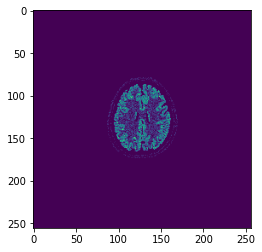

In [5]:
plt.imshow(img_noisyDataSet1[19,0,:,:])

In [6]:
# Error cuadratico medio entre dos imagenes

def MSE(img1, img2):
        cuadradoDeDif = ((img1 -img2) ** 2)
        suma = np.sum(cuadradoDeDif)
        cantPix = img1.shape[0] * img1.shape[1] 
        error = suma / cantPix
        return error

In [7]:
MSE_dataSet1_slice = MSE(img_noisyDataSet1[5,0,:,:],img_groundTruth[5,0,:,:])
print(MSE_dataSet1_slice)

0.35028509543889563


In [8]:
#Unet CLASICA (generando un nuevo formato)

class DownConv(nn.Module):
    
    def __init__(self, in_channels , out_channels):
        super(DownConv, self).__init__()
        self.DownLayer = nn.Sequential(

            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace = True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace = True),
        )
        
    def forward(self, x ):
        x = self.DownLayer(x)
        return x
    
        
class MaxPool(nn.Module):
    def __init__(self):
        super(MaxPool, self).__init__()
        self.Pool = torch.nn.MaxPool2d(kernel_size = 2)
        
    def forward (self,x):
        x = self.Pool(x)
        return x
    
        
class UpConv(nn.Module):
    
    def __init__(self, in_channels , out_channels):
        super(UpConv, self).__init__()
        
        self.ConvTransp = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        #self.ConvTransp = torch.nn.ConvTranspose2d((in_channels//2), out_channels, kernel_size = 2, stride = 2, padding = 0)
        self.UpConv = DownConv(in_channels, out_channels)
        
    def forward(self, xAnt , xDown):
            
        layerConvTransposed = self.ConvTransp(xAnt)
        concat = torch.cat([layerConvTransposed,xDown], dim=1)
        x = self.UpConv(concat)
            
        return x

class OutUnet(nn.Module):
    def __init__(self, in_channels , out_channels):
        super(OutUnet, self).__init__()
        self.OutUnet = torch.nn.Conv2d(in_channels,out_channels, kernel_size = 1)
        
    def forward(self,x):
        x = self.OutUnet(x)
        return x

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet,self).__init__()
        
        # Contract
        self.Layer1Down = DownConv(1,64)
        self.Layer2Down = DownConv(64,128)
        self.Layer3Down = DownConv(128,256)
        self.Layer4Down = DownConv(256,512)
        
        self.Middle = DownConv(512,512)
        
        self.Layer1Up = UpConv(1024,256)
        self.Layer2Up = UpConv(512,128)
        self.Layer3Up = UpConv(256,64)
        self.Layer4Up = UpConv(128,64)
        
        self.MaxPool = MaxPool()
        
        self.Out = OutUnet(64,1)
        
        
    
    def forward(self, x):

        # Down
        conv1 = self.Layer1Down(x)
        maxPool1 = self.MaxPool(conv1)
        
        conv2 = self.Layer2Down(maxPool1)
        maxPool2 = self.MaxPool(conv2)
        
        conv3 = self.Layer3Down(maxPool2)
        maxPool3 = self.MaxPool(conv3)
        
        conv4 = self.Layer4Down(maxPool3)
        maxPool4 = self.MaxPool(conv4)
        
        middle = self.Middle(maxPool4)
        
        # Up
        up1= self.Layer1Up(middle,conv4)
        up2= self.Layer2Up(up1,conv3)
        up3= self.Layer3Up(up2,conv2)
        up4= self.Layer4Up(up3,conv1)
        
        outUNet = self.Out(up4)
        
        return outUNet

unet = Unet()

In [9]:
# Entrenamiento #

# Loss and optimizer

criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.0001)

# Conjunto de entrenamiento, testeo y validacion

train_noisyImage,test_noisyImage,train_groundTruth,test_groundTruth = train_test_split(img_noisyDataSet1, img_groundTruth, test_size=0.2)

valid_noisyImage = train_noisyImage[-5:,:,:,:]
valid_groundTruth = train_groundTruth[-5:,:,:,:]

train_noisyImage = train_noisyImage [:-5,:,:,:]
train_groundTruth = train_groundTruth[:-5:,:,:,:]
    

In [10]:
if __name__ == '__main__':
    inputs = train_noisyImage[5]
    inputs = np.expand_dims(inputs, axis=-3)
    inputs = torch.Tensor(inputs)
    out = unet(inputs)


summary(unet,inputs )

Layer (type:depth-idx)                   Output Shape              Param #
├─DownConv: 1-1                          [-1, 64, 256, 256]        --
|    └─Sequential: 2-1                   [-1, 64, 256, 256]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 256, 256]        640
|    |    └─BatchNorm2d: 3-2             [-1, 64, 256, 256]        128
|    |    └─ReLU: 3-3                    [-1, 64, 256, 256]        --
|    |    └─Conv2d: 3-4                  [-1, 64, 256, 256]        36,928
|    |    └─BatchNorm2d: 3-5             [-1, 64, 256, 256]        128
|    |    └─ReLU: 3-6                    [-1, 64, 256, 256]        --
├─MaxPool: 1-2                           [-1, 64, 128, 128]        --
|    └─MaxPool2d: 2-2                    [-1, 64, 128, 128]        --
├─DownConv: 1-3                          [-1, 128, 128, 128]       --
|    └─Sequential: 2-3                   [-1, 128, 128, 128]       --
|    |    └─Conv2d: 3-7                  [-1, 128, 128, 128]       73,856
|   

Layer (type:depth-idx)                   Output Shape              Param #
├─DownConv: 1-1                          [-1, 64, 256, 256]        --
|    └─Sequential: 2-1                   [-1, 64, 256, 256]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 256, 256]        640
|    |    └─BatchNorm2d: 3-2             [-1, 64, 256, 256]        128
|    |    └─ReLU: 3-3                    [-1, 64, 256, 256]        --
|    |    └─Conv2d: 3-4                  [-1, 64, 256, 256]        36,928
|    |    └─BatchNorm2d: 3-5             [-1, 64, 256, 256]        128
|    |    └─ReLU: 3-6                    [-1, 64, 256, 256]        --
├─MaxPool: 1-2                           [-1, 64, 128, 128]        --
|    └─MaxPool2d: 2-2                    [-1, 64, 128, 128]        --
├─DownConv: 1-3                          [-1, 128, 128, 128]       --
|    └─Sequential: 2-3                   [-1, 128, 128, 128]       --
|    |    └─Conv2d: 3-7                  [-1, 128, 128, 128]       73,856
|   

In [11]:
# Prueba con un slice 
if __name__ == '__main__':
    inputs = train_noisyImage[5]
    inputs = np.expand_dims(inputs, axis=-3)
    inputs = torch.Tensor(inputs)
    out = unet(inputs)
    
gT = train_groundTruth[5]
gT = np.expand_dims(gT, axis=-3)
gT = torch.Tensor(gT)

inputs_np = inputs.detach().numpy()
out_np = out.detach().numpy()
gT_np = gT.detach().numpy()

MSE_orig = MSE(inputs_np[0,0,:,:],gT_np[0,0,:,:])
MSE_test = MSE(out_np[0,0,:,:],gT_np[0,0,:,:])

print('MSE orig', MSE_orig)
print('MSE test', MSE_test)


# Guardar imgs en formato .nii

img_inputs = sitk.GetImageFromArray(inputs_np[0,0,:,:])
sitk.WriteImage(img_inputs,'inputsNoTrain.nii')

img_out = sitk.GetImageFromArray(out_np[0,0,:,:])
sitk.WriteImage(img_out,'outNoTrain.nii')

img_gT = sitk.GetImageFromArray(gT_np[0,0,:,:])
sitk.WriteImage(img_gT,'groundTruthNoTrain.nii')

MSE orig 0.3794829547405243
MSE test 3.5864291191101074


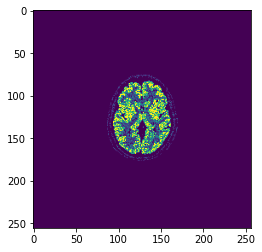

In [12]:
scaleForVisualization = 1.2*gT_np.max()

plt.imshow(inputs_np[0,0,:,:] , vmin = 0, vmax = scaleForVisualization)

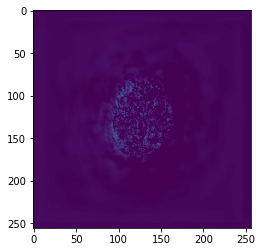

In [13]:
plt.imshow(out_np[0,0,:,:] , vmin = 0, vmax = scaleForVisualization)

In [12]:
# Codigo de pag Pythorch
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    for i in range(0, train_noisyImage.shape[0]):
        
        # Acondicionamiento de datos
        
        inputs = train_noisyImage[i]
        inputs = np.expand_dims(inputs, axis=-3)
        inputs = torch.Tensor(inputs)
        
        trainGroundTruth = train_groundTruth[i]
        trainGroundTruth = np.expand_dims(trainGroundTruth, axis=-3)
        trainGroundTruth = torch.Tensor(trainGroundTruth)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(inputs)
        loss = criterion(outputs, trainGroundTruth)

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss en las ultimas 10 imagenes
            print('  image {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * ((train_noisyImage.shape[0])/10) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [13]:
# Initializing in a separate cell so we can easily add more epochs to the same run

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 10

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    unet.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    unet.train(False)

    running_vloss = 0.0
    for i in range(0, valid_noisyImage.shape[0]):
        
        vinputs = valid_noisyImage[i]
        vinputs = np.expand_dims(vinputs, axis=-3)
        vinputs = torch.Tensor(vinputs)
        
        validGroundTruth = valid_groundTruth[i]
        validGroundTruth = np.expand_dims(validGroundTruth, axis=-3)
        validGroundTruth = torch.Tensor(validGroundTruth)
        
        voutputs = unet(vinputs)
        vloss =  criterion(voutputs, validGroundTruth)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        unet_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(unet.state_dict(), unet_path)

    epoch_number += 1

EPOCH 1:
  image 10 loss: 1.5439619839191436
LOSS train 1.5439619839191436 valid 1.5556118488311768
EPOCH 2:
  image 10 loss: 0.7313589930534363
LOSS train 0.7313589930534363 valid 0.8237413167953491
EPOCH 3:
  image 10 loss: 0.5848213195800781
LOSS train 0.5848213195800781 valid 0.46677738428115845
EPOCH 4:
  image 10 loss: 0.5026190429925919
LOSS train 0.5026190429925919 valid 0.3765321373939514
EPOCH 5:
  image 10 loss: 0.4443620562553406
LOSS train 0.4443620562553406 valid 0.3789449632167816
EPOCH 6:
  image 10 loss: 0.39828391671180724
LOSS train 0.39828391671180724 valid 0.36765432357788086
EPOCH 7:
  image 10 loss: 0.361507810652256
LOSS train 0.361507810652256 valid 0.3471493721008301
EPOCH 8:
  image 10 loss: 0.3303921952843666
LOSS train 0.3303921952843666 valid 0.3275739550590515
EPOCH 9:
  image 10 loss: 0.30234447568655015
LOSS train 0.30234447568655015 valid 0.3294169306755066
EPOCH 10:
  image 10 loss: 0.27316983342170714
LOSS train 0.27316983342170714 valid 0.2978470325

In [16]:
# CONJUNTO DE ENTRENAMIENTO

if __name__ == '__main__':
    inputsTrain = train_noisyImage[1]
    inputsTrain = np.expand_dims(inputsTrain, axis=-3)
    inputsTrain = torch.Tensor(inputsTrain)
    model = Unet()
    outTrain = unet(inputsTrain)
    
gTtrain = train_groundTruth[1]
gTtrain = np.expand_dims(gTtrain, axis=-3)
gTtrain = torch.Tensor(gTtrain)

inputsTrain_np = inputsTrain.detach().numpy()
outTrain_np = outTrain.detach().numpy()
gTtrain_np = gTtrain.detach().numpy()

# MSE antes y dsp

MSE_orig = MSE(inputsTrain_np[0,0,:,:],gTtrain_np[0,0,:,:])
MSE_test = MSE(outTrain_np[0,0,:,:],gTtrain_np[0,0,:,:])

print('MSE orig', MSE_orig)
print('MSE test', MSE_test)

# Guardar imgs en formato .nii

img_inputs = sitk.GetImageFromArray(inputsTrain_np[0,0,:,:])
sitk.WriteImage(img_inputs,'inputsTrain.nii')

img_out = sitk.GetImageFromArray(outTrain_np[0,0,:,:])
sitk.WriteImage(img_out,'outTrain.nii')

img_gTtest = sitk.GetImageFromArray(gTtrain_np[0,0,:,:])
sitk.WriteImage(img_gT,'groundTruthtrain.nii')

MSE orig 0.3699556589126587
MSE test 0.13618408143520355


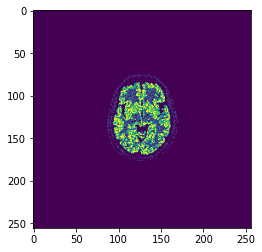

In [17]:
plt.imshow(inputsTrain_np[0,0,:,:] , vmin = 0, vmax = scaleForVisualization)

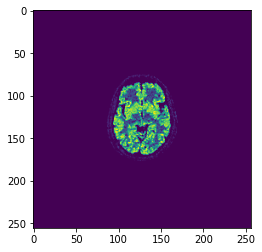

In [18]:
plt.imshow(outTrain_np[0,0,:,:] ,vmin = 0, vmax = scaleForVisualization )

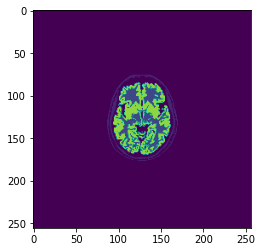

In [19]:
plt.imshow(gTtrain_np[0,0,:,:] ,vmin = 0, vmax = scaleForVisualization )

In [20]:
# CONJUNTO DE TESTEO

if __name__ == '__main__':
    inputsTest = test_noisyImage[1]
    inputsTest = np.expand_dims(inputsTest, axis=-3)
    inputsTest = torch.Tensor(inputsTest)
    model = Unet()
    outTest = unet(inputsTest)
    
gTtest = test_groundTruth[1]
gTtest = np.expand_dims(gTtest, axis=-3)
gTtest = torch.Tensor(gTtest)

inputsTest_np = inputsTest.detach().numpy()
outTest_np = outTest.detach().numpy()
gTtest_np = gTtest.detach().numpy()

# MSE antes y dsp

MSE_orig = MSE(inputsTest_np[0,0,:,:],gTtest_np[0,0,:,:])
MSE_test = MSE(outTest_np[0,0,:,:],gTtest_np[0,0,:,:])

print('MSE orig', MSE_orig)
print('MSE test', MSE_test)

# Guardar imgs en formato .nii

img_inputs = sitk.GetImageFromArray(inputsTest_np[0,0,:,:])
sitk.WriteImage(img_inputs,'inputsTest.nii')

img_out = sitk.GetImageFromArray(outTest_np[0,0,:,:])
sitk.WriteImage(img_out,'outTest.nii')

img_gTtest = sitk.GetImageFromArray(gTtest_np[0,0,:,:])
sitk.WriteImage(img_gT,'groundTruthtest.nii')

MSE orig 0.3362330198287964
MSE test 0.14730237424373627


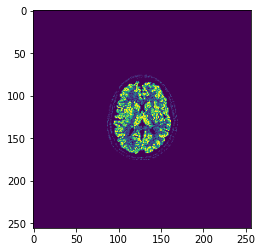

In [21]:
plt.imshow(inputsTest_np[0,0,:,:] , vmin = 0, vmax = scaleForVisualization)

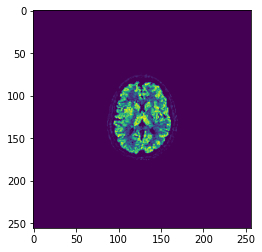

In [22]:
plt.imshow(outTest_np[0,0,:,:] ,vmin = 0, vmax = scaleForVisualization )